### 9.2 Activity: Jupyter Notebook – Gradient Boost

For this week, include ideas such as gradient boost, learning rate, number of estimators, tree depth, and regularization. This homework should be submitted for peer review in the assignment titled 9.3 Peer Review: Week 9 Jupyter Notebook. Complete and submit your Jupyter Notebook homework by 11:59pm ET on Sunday. 

Ok the plan:
- Try a vanilla GBM on all 3 datasets, with some tuning
- Go ahead and drop in XGBoost Classifier and XGBoost Regressor and try some model tuning

In [1]:
! nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 5090 (UUID: GPU-f7f57dfb-5480-a1d6-1870-ac9f5f47ce36)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
X= pd.read_csv('scripts/punt_analytics/motion_features_X_full.csv')
y = pd.read_csv('scripts/punt_analytics/motion_labels_y_full.csv')['concussed']

# First, split the ORIGINAL data before any resampling
X_original_train, X_holdout, y_original_train, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original holdout distribution:")
print(f"Holdout set: {pd.Series(y_holdout).value_counts()}")
print(f"Training set: {pd.Series(y_original_train).value_counts()}")

# Resample only the training data
undersample = RandomUnderSampler(sampling_strategy=0.01)
oversample = SMOTE(sampling_strategy=0.1)

pipeline = ImbPipeline([
    ('undersample', undersample),
    ('oversample', oversample)
])

X_resampled, y_resampled = pipeline.fit_resample(X_original_train, y_original_train)


Original holdout distribution:
Holdout set: concussed
0    54544
1        6
Name: count, dtype: int64
Training set: concussed
0    218172
1        26
Name: count, dtype: int64


In [5]:
X_resampled.shape, X_holdout.shape, y_resampled.shape, y_holdout.shape

((2860, 240), (54550, 240), (2860,), (54550,))

In [6]:
def create_lag_features_optimized(df):
    """Optimized lag feature creation - builds all features at once"""
    variables = ['dis', 'o',  'x', 'y']
    
    # Collect all new columns in a list first
    new_columns = {}
    
    for var in variables:
        cols = [f'{var}_slice_{i}' for i in range(10)]
        
        # Create lag features (previous time steps)
        for lag in [1, 2, 3]:
            for i in range(lag, 10):
                col_name = f'{var}_slice_{i}_lag{lag}'
                new_columns[col_name] = df[f'{var}_slice_{i-lag}'].values
        
        # Create lead features (future time steps)  
        for lead in [1, 2]:
            for i in range(10-lead):
                col_name = f'{var}_slice_{i}_lead{lead}'
                new_columns[col_name] = df[f'{var}_slice_{i+lead}'].values
    
    # Create new dataframe with all lag/lead features at once
    new_features_df = pd.DataFrame(new_columns, index=df.index)
    
    # Concatenate with original dataframe
    result_df = pd.concat([df, new_features_df], axis=1)
    
    return result_df

def create_time_series_features_optimized(df):
    """Optimized statistical time series feature creation"""
    variables = ['dis', 'o', 'x', 'y']

    # Collect all new features
    new_features = {}
    
    for var in variables:
        cols = [f'{var}_slice_{i}' for i in range(10)]
        
        # Get the data matrix for this variable (all time slices)
        data_matrix = df[cols].values
        
        # Compute all statistical features vectorized
        new_features[f'{var}_trend'] = np.nanmean(np.diff(data_matrix, axis=1), axis=1)
        new_features[f'{var}_slope'] = (data_matrix[:, -1] - data_matrix[:, 0]) / 9
        new_features[f'{var}_mean'] = np.nanmean(data_matrix, axis=1)
        new_features[f'{var}_std'] = np.nanstd(data_matrix, axis=1)
        new_features[f'{var}_min'] = np.nanmin(data_matrix, axis=1)
        new_features[f'{var}_max'] = np.nanmax(data_matrix, axis=1)
        new_features[f'{var}_range'] = new_features[f'{var}_max'] - new_features[f'{var}_min']
        
        # Change point features
        new_features[f'{var}_early_mean'] = np.nanmean(data_matrix[:, :3], axis=1)
        new_features[f'{var}_late_mean'] = np.nanmean(data_matrix[:, 7:], axis=1)
        new_features[f'{var}_early_late_diff'] = new_features[f'{var}_late_mean'] - new_features[f'{var}_early_mean']
        
        # Volatility features
        new_features[f'{var}_volatility'] = np.nanstd(np.diff(data_matrix, axis=1), axis=1)
        
        # Pattern recognition features
        diff_matrix = np.diff(data_matrix, axis=1)
        new_features[f'{var}_monotonic_increase'] = np.sum(diff_matrix > 0, axis=1)
        new_features[f'{var}_monotonic_decrease'] = np.sum(diff_matrix < 0, axis=1)
        
        # Direction changes (second derivative)
        second_diff = np.diff(diff_matrix, axis=1)
        new_features[f'{var}_direction_changes'] = np.sum(second_diff != 0, axis=1)
        
        # Coefficient of variation (handle division by zero)
        means = new_features[f'{var}_mean']
        stds = new_features[f'{var}_std']
        new_features[f'{var}_coefficient_variation'] = np.where(
            np.abs(means) > 1e-8, 
            stds / np.abs(means), 
            0
        )
        
        # Time-weighted features (recent values matter more)
        weights = np.arange(1, 11)  # 1, 2, 3, ..., 10
        weighted_sum = np.sum(data_matrix * weights, axis=1)
        new_features[f'{var}_weighted_mean'] = weighted_sum / np.sum(weights)
    
    # Create dataframe from all new features
    new_features_df = pd.DataFrame(new_features, index=df.index)
    
    # Concatenate with original
    result_df = pd.concat([df, new_features_df], axis=1)
    
    return result_df

def create_interaction_features_optimized(df):
    """Optimized interaction feature creation"""
    new_features = {}
    
    # Cross-variable interactions at each time slice
    for i in range(10):
        new_features[f'x_y_interaction_{i}'] = df[f'x_slice_{i}'] * df[f'y_slice_{i}']
        new_features[f'dis_o_interaction_{i}'] = df[f'dis_slice_{i}'] * df[f'o_slice_{i}']
        
        # Distance-like features
        new_features[f'euclidean_distance_{i}'] = np.sqrt(
            df[f'x_slice_{i}']**2 + df[f'y_slice_{i}']**2
        )
        
        # Angle-like features (if o represents orientation)
        new_features[f'velocity_x_{i}'] = df[f'dis_slice_{i}'] * np.cos(df[f'o_slice_{i}'])
        new_features[f'velocity_y_{i}'] = df[f'dis_slice_{i}'] * np.sin(df[f'o_slice_{i}'])
    
    # Multi-variable aggregate features
    x_cols = [f'x_slice_{i}' for i in range(10)]
    y_cols = [f'y_slice_{i}' for i in range(10)]
    dis_cols = [f'dis_slice_{i}' for i in range(10)]
    
    # Total displacement path
    x_data = df[x_cols].values
    y_data = df[y_cols].values
    
    new_features['total_displacement'] = np.sqrt(
        (x_data[:, -1] - x_data[:, 0])**2 + 
        (y_data[:, -1] - y_data[:, 0])**2
    )
    
    # Path efficiency (straight line vs actual path)
    total_distance = np.sum(df[dis_cols].values, axis=1)
    new_features['path_efficiency'] = np.where(
        total_distance > 1e-8,
        new_features['total_displacement'] / total_distance,
        0
    )
    
    # Create dataframe and concatenate
    new_features_df = pd.DataFrame(new_features, index=df.index)
    result_df = pd.concat([df, new_features_df], axis=1)
    
    return result_df

def create_all_time_series_features(df):
    """Create all time series features efficiently"""
    print("Creating lag/lead features...")
    df = create_lag_features_optimized(df)
    
    print("Creating statistical features...")
    df = create_time_series_features_optimized(df)
    
    print("Creating interaction features...")
    df = create_interaction_features_optimized(df)
    
    # Defragment the dataframe
    print("Defragmenting dataframe...")
    df = df.copy()
    
    print(f"Final shape: {df.shape}")
    return df

# Usage:
# df_enhanced = create_all_time_series_features(df)
# 
# This will be much faster and won't generate performance warnings!

X_train = create_all_time_series_features(X_resampled)
X_holdout = create_all_time_series_features(X_holdout)

Creating lag/lead features...
Creating statistical features...
Creating interaction features...
Defragmenting dataframe...
Final shape: (2860, 520)
Creating lag/lead features...
Creating statistical features...
Creating interaction features...
Defragmenting dataframe...


/tmp/ipykernel_48939/28632552.py:75: RuntimeWarning: invalid value encountered in divide
  stds / np.abs(means),
/tmp/ipykernel_48939/28632552.py:128: RuntimeWarning: divide by zero encountered in divide
  new_features['total_displacement'] / total_distance,
/tmp/ipykernel_48939/28632552.py:128: RuntimeWarning: invalid value encountered in divide
  new_features['total_displacement'] / total_distance,
/tmp/ipykernel_48939/28632552.py:75: RuntimeWarning: invalid value encountered in divide
  stds / np.abs(means),
/tmp/ipykernel_48939/28632552.py:128: RuntimeWarning: divide by zero encountered in divide
  new_features['total_displacement'] / total_distance,
/tmp/ipykernel_48939/28632552.py:128: RuntimeWarning: invalid value encountered in divide
  new_features['total_displacement'] / total_distance,


Final shape: (54550, 520)


In [7]:
y_resampled.value_counts()

concussed
0    2600
1     260
Name: count, dtype: int64

In [8]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix as conf_matrix, roc_auc_score, log_loss
import numpy as np
import pandas as pd

def diagnose_and_train_xgboost_classifier(X, y, use_time_split=False, test_size=0.2):
    """
    Comprehensive XGBoost CLASSIFICATION training with diagnostics
    
    Parameters:
    -----------
    X : DataFrame - Features
    y : Series/array - Target variable (class labels)
    use_time_split : bool - Whether to use TimeSeriesSplit (only if rows are temporally ordered)
    test_size : float - Test set proportion
    """
    
    print("=== DATA DIAGNOSTICS ===")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target classes and counts:")
    print(pd.Series(y).value_counts().sort_index())
    print(f"Class balance:")
    for class_val in sorted(pd.Series(y).unique()):
        prop = (pd.Series(y) == class_val).mean()
        print(f"  Class {class_val}: {prop:.3f} ({prop*100:.1f}%)")
    
    # Determine if binary or multiclass
    n_classes = len(pd.Series(y).unique())
    is_binary = n_classes == 2
    print(f"Number of classes: {n_classes}")
    print(f"Problem type: {'Binary' if is_binary else 'Multiclass'} Classification")
    
    # Split data
    if use_time_split:
        print("\n=== CHECKING TIME SERIES SPLIT FEASIBILITY ===")
        # Check if temporal split will have positive cases in test set
        split_point = int(len(X) * (1 - test_size))
        y_test_temp = y.iloc[split_point:]
        positive_in_test = y_test_temp.sum()
        
        print(f"Temporal split would put {positive_in_test} positive cases in test set")
        
        if positive_in_test < 5:  # Minimum threshold for meaningful evaluation
            print(f"WARNING: Only {positive_in_test} positive cases in temporal test set!")
            print("Falling back to stratified random split to ensure proper evaluation...")
            
            # Fall back to stratified split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y
            )
            cv_method = 5  # Regular 5-fold CV
            print("=== USING STRATIFIED RANDOM SPLIT (fallback) ===")
        else:
            print("=== USING TIME SERIES SPLIT ===")
            # For actual time series data where row order matters
            X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
            y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
            cv_method = TimeSeriesSplit(n_splits=5)
    else:
        print("\n=== USING RANDOM SPLIT ===")
        # For independent sequences (more likely for your data)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        cv_method = 5  # Regular 5-fold CV
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # XGBoost parameters for classification
    if is_binary:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 4,
            'learning_rate': 0.1,
            'n_estimators': 500,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42,
            'device': 'cuda',      # GPU acceleration
            'tree_method': 'hist', # Required for GPU
            'n_jobs': 1           # Use 1 job when using GPU
        }
        model = xgb.XGBClassifier(**params)
    else:
        params = {
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'max_depth': 4,
            'learning_rate': 0.1,
            'n_estimators': 500,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42,
            'device': 'cuda',      # GPU acceleration
            'tree_method': 'hist', # Required for GPU
            'n_jobs': 1           # Use 1 job when using GPU
        }
        model = xgb.XGBClassifier(**params)
    
    print("\n=== MODEL TRAINING ===")
    
    # Cross-validation with appropriate scoring
    scoring_metric = 'roc_auc' if is_binary else 'accuracy'
    
    if use_time_split:
        cv_scores = []
        for train_idx, val_idx in cv_method.split(X_train):
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            temp_model = xgb.XGBClassifier(**params)
            temp_model.fit(X_cv_train, y_cv_train, verbose=False)
            
            if is_binary:
                y_pred_proba = temp_model.predict_proba(X_cv_val)[:, 1]
                score = roc_auc_score(y_cv_val, y_pred_proba)
            else:
                score = temp_model.score(X_cv_val, y_cv_val)
            cv_scores.append(score)
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_method, scoring=scoring_metric)
    
    print(f"Cross-validation {scoring_metric} scores: {cv_scores}")
    print(f"Mean CV {scoring_metric}: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    
    # Train final model
    model.fit(X_train, y_train, verbose=False)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if is_binary:
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = model.predict_proba(X_train)
        y_pred_proba_test = model.predict_proba(X_test)
    
    print("\n=== EVALUATION METRICS ===")
    print("Training Set:")
    print(f"  Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    if is_binary:
        print(f"  AUC-ROC: {roc_auc_score(y_train, y_pred_proba_train):.4f}")
        print(f"  Log Loss: {log_loss(y_train, y_pred_proba_train):.4f}")
    else:
        print(f"  Log Loss: {log_loss(y_train, y_pred_proba_train):.4f}")
    
    print("\nTest Set:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    if is_binary:
        print(f"  AUC-ROC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
        print(f"  Log Loss: {log_loss(y_test, y_pred_proba_test):.4f}")
    else:
        print(f"  Log Loss: {log_loss(y_test, y_pred_proba_test):.4f}")
    
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(y_test, y_pred_test))
    
    print("\n=== CONFUSION MATRIX ===")
    cm = conf_matrix(y_test, y_pred_test)
    print(cm)
    
    # Feature importance
    print("\n=== TOP 10 FEATURE IMPORTANCES ===")
    
    # Handle both DataFrame and NumPy array inputs
    if hasattr(X, 'columns'):
        feature_names = X.columns
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10))
    
    # Baseline comparison
    majority_class = pd.Series(y_train).mode()[0]
    baseline_accuracy = (pd.Series(y_test) == majority_class).mean()
    
    print(f"\n=== BASELINE COMPARISON ===")
    print(f"Baseline accuracy (majority class): {baseline_accuracy:.4f}")
    print(f"Model improvement over baseline: {accuracy_score(y_test, y_pred_test) - baseline_accuracy:.4f}")
    
    return model, {
        'cv_scores': cv_scores,
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'test_auc': roc_auc_score(y_test, y_pred_proba_test) if is_binary else None,
        'test_logloss': log_loss(y_test, y_pred_proba_test),
        'feature_importance': feature_importance,
        'classification_report': classification_report(y_test, y_pred_test, output_dict=True),
        'confusion_matrix': conf_matrix(y_test, y_pred_test),
        'y_pred_test': y_pred_test,
        'y_pred_proba_test': y_pred_proba_test,
        'y_test': y_test
    }

# Alternative: Simple baseline models for comparison
def test_baseline_classifiers(X, y):
    """Test simple baseline classification models"""
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.dummy import DummyClassifier
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Majority Class': DummyClassifier(strategy='most_frequent'),
        'Stratified': DummyClassifier(strategy='stratified', random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[name] = accuracy
        print(f"{name}: Accuracy = {accuracy:.4f}")
    
    return results

# Usage examples:
# model, results = diagnose_and_train_xgboost_classifier(X, y, use_time_split=False)
# baseline_results = test_baseline_classifiers(X, y)

In [9]:
model, results = diagnose_and_train_xgboost_classifier(X_train, y_resampled, use_time_split=False)

=== DATA DIAGNOSTICS ===
Features shape: (2860, 520)
Target shape: (2860,)
Target classes and counts:
concussed
0    2600
1     260
Name: count, dtype: int64
Class balance:
  Class 0: 0.909 (90.9%)
  Class 1: 0.091 (9.1%)
Number of classes: 2
Problem type: Binary Classification

=== USING RANDOM SPLIT ===
Training set: 2288 samples
Test set: 572 samples

=== MODEL TRAINING ===


/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:04:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738899731441/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Cross-validation roc_auc scores: [0.99730998 0.9981685  0.98511905 0.99953096 0.99894465]
Mean CV roc_auc: 0.9958 (+/- 0.0108)

=== EVALUATION METRICS ===
Training Set:
  Accuracy: 1.0000
  AUC-ROC: 1.0000
  Log Loss: 0.0016

Test Set:
  Accuracy: 0.9930
  AUC-ROC: 0.9977
  Log Loss: 0.0239

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       0.96      0.96      0.96        52

    accuracy                           0.99       572
   macro avg       0.98      0.98      0.98       572
weighted avg       0.99      0.99      0.99       572


=== CONFUSION MATRIX ===
[[518   2]
 [  2  50]]

=== TOP 10 FEATURE IMPORTANCES ===
                   feature  importance
327         x_slice_6_lag1    0.048116
183              o_slice_3    0.028349
422                 o_mean    0.024464
354        x_slice_8_lead1    0.023177
207             o_slice_27    0.022909
250       dis_slice_3_lag2    0

In [10]:
y_holdout_pred = model.predict(X_holdout)
y_holdout_pred_proba = model.predict_proba(X_holdout)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score, log_loss, confusion_matrix as conf_matrix

print("Classification Report:")
print(classification_report(y_holdout, y_holdout_pred))

print("ROC AUC Score:")
print(roc_auc_score(y_holdout, y_holdout_pred_proba))

print("Log Loss:")
print(log_loss(y_holdout, y_holdout_pred_proba))

print("Confusion Matrix:")
print(conf_matrix(y_holdout, y_holdout_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54544
           1       0.00      0.00      0.00         6

    accuracy                           1.00     54550
   macro avg       0.50      0.50      0.50     54550
weighted avg       1.00      1.00      1.00     54550

ROC AUC Score:
0.7355743375378899
Log Loss:
0.00670195980775645
Confusion Matrix:
[[54494    50]
 [    6     0]]


In [11]:
# Compare feature distributions
print("Training data feature means:")
print(X_train.mean())
print("\nHoldout data feature means:")
print(X_holdout.mean())

# Check for significant differences
from scipy.stats import ks_2samp
for col in X_train.columns:
    stat, p_value = ks_2samp(X_train[col], X_holdout[col])
    if p_value < 0.01:
        print(f"Significant difference in {col}: p={p_value:.6f}")

Training data feature means:
dis_slice_0              0.257267
dis_slice_1              0.168011
dis_slice_2              0.156045
dis_slice_3              0.151671
dis_slice_4              0.146840
                          ...    
euclidean_distance_9    69.023011
velocity_x_9             0.003761
velocity_y_9            -0.003671
total_displacement       3.504035
path_efficiency          2.458697
Length: 520, dtype: float64

Holdout data feature means:
dis_slice_0              0.277356
dis_slice_1              0.174964
dis_slice_2              0.157008
dis_slice_3              0.150816
dis_slice_4              0.148958
                          ...    
euclidean_distance_9    68.080710
velocity_x_9             0.001048
velocity_y_9             0.000198
total_displacement       3.389112
path_efficiency          2.385138
Length: 520, dtype: float64
Significant difference in dis_slice_0: p=0.003794
Significant difference in dis_slice_1: p=0.005982
Significant difference in dis_slice_42

In [12]:
X_train.columns

Index(['dis_slice_0', 'dis_slice_1', 'dis_slice_2', 'dis_slice_3',
       'dis_slice_4', 'dis_slice_5', 'dis_slice_6', 'dis_slice_7',
       'dis_slice_8', 'dis_slice_9',
       ...
       'euclidean_distance_8', 'velocity_x_8', 'velocity_y_8',
       'x_y_interaction_9', 'dis_o_interaction_9', 'euclidean_distance_9',
       'velocity_x_9', 'velocity_y_9', 'total_displacement',
       'path_efficiency'],
      dtype='object', length=520)

### try again with our resampled dataset

In [13]:
model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',  # Use GPU acceleration
    tree_method='hist',  # Required for GPU
    n_jobs=1  # Use 1 job when using GPU
)

model.fit(X_train, y_resampled, eval_set=[(X_holdout, y_holdout)],verbose=True)

[0]	validation_0-logloss:0.16570
[1]	validation_0-logloss:0.15346
[2]	validation_0-logloss:0.14296
[3]	validation_0-logloss:0.13299
[4]	validation_0-logloss:0.12517
[5]	validation_0-logloss:0.11673
[6]	validation_0-logloss:0.11053
[7]	validation_0-logloss:0.10359
[8]	validation_0-logloss:0.09765
[9]	validation_0-logloss:0.09221
[10]	validation_0-logloss:0.08805
[11]	validation_0-logloss:0.08341
[12]	validation_0-logloss:0.07867
[13]	validation_0-logloss:0.07417
[14]	validation_0-logloss:0.07133
[15]	validation_0-logloss:0.06870
[16]	validation_0-logloss:0.06538
[17]	validation_0-logloss:0.06229
[18]	validation_0-logloss:0.06026
[19]	validation_0-logloss:0.05698
[20]	validation_0-logloss:0.05418
[21]	validation_0-logloss:0.05219
[22]	validation_0-logloss:0.05039
[23]	validation_0-logloss:0.04791
[24]	validation_0-logloss:0.04681
[25]	validation_0-logloss:0.04465
[26]	validation_0-logloss:0.04337
[27]	validation_0-logloss:0.04235
[28]	validation_0-logloss:0.04073
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=1,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
y_holdout_pred = model.predict(X_holdout)
y_holdout_pred_proba = model.predict_proba(X_holdout)[:, 1]
print("Classification Report:")
print(classification_report(y_holdout, y_holdout_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_holdout, y_holdout_pred_proba))
print("Log Loss:")
print(log_loss(y_holdout, y_holdout_pred_proba))
print("Confusion Matrix:")
print(conf_matrix(y_holdout, y_holdout_pred))
print("Feature Importances:")
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(feature_importance_df.head(10))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54544
           1       0.00      0.00      0.00         6

    accuracy                           1.00     54550
   macro avg       0.50      0.50      0.50     54550
weighted avg       1.00      1.00      1.00     54550

ROC AUC Score:
0.6701989830839934
Log Loss:
0.005156602041139079
Confusion Matrix:
[[54516    28]
 [    6     0]]
Feature Importances:
                   feature  importance
333         x_slice_4_lag2    0.085737
342         x_slice_6_lag3    0.028481
373         y_slice_3_lag2    0.027985
514    dis_o_interaction_9    0.023468
408                dis_min    0.023115
243       dis_slice_4_lag1    0.020086
417  dis_direction_changes    0.017937
73              x_slice_13    0.015915
284         o_slice_4_lag1    0.015676
116             x_slice_56    0.014406


In [15]:
print(f"Probability scores for the 6 actual concussions:")
print(y_holdout_pred_proba[y_holdout == 1].round(2))  

Probability scores for the 6 actual concussions:
[0.   0.   0.   0.   0.01 0.  ]


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter distribution
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier(objective='binary:logistic', device='cuda', tree_method='hist', n_jobs=1)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Or 'accuracy', 'f1', etc.
    cv=5,       # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=1   # Use all available cores
)

# Fit the search to your data
random_search.fit(X_train, y_resampled)

# Get the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best ROC AUC score: ", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

[0]	validation_0-auc:0.91537
[1]	validation_0-auc:0.94467
[2]	validation_0-auc:0.95298
[3]	validation_0-auc:0.97536
[4]	validation_0-auc:0.97302
[5]	validation_0-auc:0.96835
[6]	validation_0-auc:0.97498
[7]	validation_0-auc:0.97734
[8]	validation_0-auc:0.97602
[9]	validation_0-auc:0.97890
[10]	validation_0-auc:0.98586
[11]	validation_0-auc:0.98516
[12]	validation_0-auc:0.98318
[13]	validation_0-auc:0.98532
[14]	validation_0-auc:0.98668
[15]	validation_0-auc:0.98608
[16]	validation_0-auc:0.98684
[17]	validation_0-auc:0.98738
[18]	validation_0-auc:0.98667
[19]	validation_0-auc:0.98828
[20]	validation_0-auc:0.98735
[21]	validation_0-auc:0.98835
[22]	validation_0-auc:0.98979
[23]	validation_0-auc:0.98882
[24]	validation_0-auc:0.98898
[25]	validation_0-auc:0.98893
[26]	validation_0-auc:0.98900
[27]	validation_0-auc:0.98803
[28]	validation_0-auc:0.98755
[29]	validation_0-auc:0.98791
[30]	validation_0-auc:0.98837
[31]	validation_0-auc:0.98782
[32]	validation_0-auc:0.98806
[33]	validation_0-au

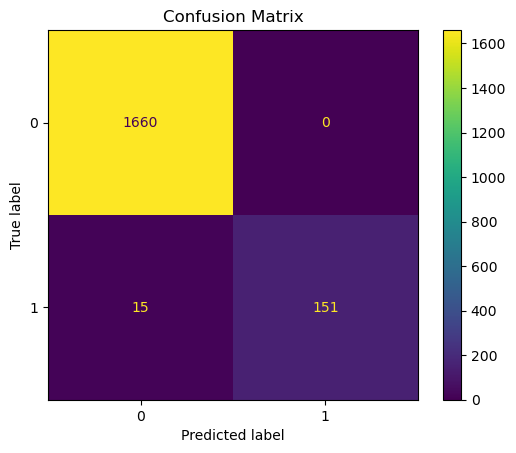

In [6]:
# 6. Define the XGBoost model
model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',        # Use GPU acceleration
    eval_metric='auc'   # Handle imbalance
)

# 7. Train the model
model.fit(
    X_param_train,
    y_param_train,
    eval_set=[(X_param_val, y_param_val)],
    verbose=True
)

# 8. Predict and evaluate
y_pred = model.predict(X_param_val)
y_pred_proba = model.predict_proba(X_param_val)[:, 1]

# Classification report
print(classification_report(y_param_val, y_pred))

# AUC score
auc = roc_auc_score(y_param_val, y_pred_proba)
print(f"AUC Score: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_param_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

Initial results are pretty good for an untuned model: we've greatly reduced the False Positive Rate over the other models without losing any accuracy. Using the confusion matrix and AUC as my preferred evaluation metrics, let's try some tuning:

In [8]:
learning_rates = [0.01, 0.03, 0.05, 0.1]
results = []

for lr in learning_rates:
    model = XGBClassifier(
        n_estimators=500,
        objective='binary:logistic',
        learning_rate=lr,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results.append((lr, auc))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results], [x[1] for x in results], marker='o')
plt.title('AUC Score vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('AUC Score')
plt.xticks(learning_rates)
plt.grid()
plt.show()

NameError: name 'pos_weight' is not defined

The various LR values don't seem to have a meaningful impact on the AUC score, dropping off slightly but then rebounding as we hit the end of the loop. 

In [ ]:
max_depths = [3, 4, 5, 6, 7, 8, 9, 10]
results_depth = []

for depth in max_depths:
    model = XGBClassifier(
        n_estimators=500,
        objective='binary:logistic',
        learning_rate=0.03,
        max_depth=depth,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_depth.append((depth, auc))
    best_depth = depth if auc == max([x[1] for x in results_depth]) else best_depth


best_model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=best_depth,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_depth], [x[1] for x in results_depth], marker='o')
plt.title('AUC Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('AUC Score')
plt.xticks(max_depths)
plt.grid()
plt.show()

Max Depth is a little more interesting. Here the shallower models perform significantly better on the test set, suggesting that the model is overfitting when tree depth is increased. 

In [ ]:
subsample_rates = [0.5, 0.6, 0.7, 0.8, 0.9]
results_subsample = []

for rate in subsample_rates:
    model = XGBClassifier(
        n_estimators=500,
        objective='binary:logistic',
        learning_rate=0.03,
        max_depth=best_depth,
        subsample=rate,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_subsample.append((rate, auc))

# print classification report for best subsample rate
best_subsample_rate = max(results_subsample, key=lambda x: x[1])[0]
best_model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=best_depth,
    subsample=best_subsample_rate,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_subsample], [x[1] for x in results_subsample], marker='o')
plt.title('AUC Score vs Subsample Rate')
plt.xlabel('Subsample Rate')
plt.ylabel('AUC Score')
plt.xticks(subsample_rates)
plt.grid()
plt.show()

The subsample rate will adjust the Fraction of rows sampled per tree. Values < 1.0 add randomness and reduce overfitting. This is another Regularization technique to confol overfitting. Looks like .8 is the sweetspot here. 

Now let's put it all together with our best model:

In [ ]:
best_model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=best_depth,
    subsample=best_subsample_rate,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Next, onto our 2nd classification set:

In [ ]:
df = pd.read_csv('/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/NFL-Punt-Analytics-Competition/processed_punt_data.csv')
# Get boolean columns
boolean_columns = df.select_dtypes(include='bool').columns

# Convert boolean columns to integers (True -> 1, False -> 0)
for col in boolean_columns:
    df[col] = df[col].astype(int)

# Display the first few rows to verify the conversion
print("Boolean columns converted to integers:")
print(df[boolean_columns].head())
df = df.drop(columns=['season_year', 'gamekey', 'playid', 'gsisid'])

# create X and y
X = df.drop(columns=['injury'])
y = df['injury']

# Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
)

For fun, let's try our best parameters from the previous model and see what we get:

In [ ]:
from sklearn.metrics import confusion_matrix

# compute class imbalance weight: 
pos_weight = (len(y) - sum(y)) / sum(y)

# fit a basic xgboost classifier
model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred))

Now we're getting somewhere: this is the best classification score I've ever pulled on this dataset. Let's try our tuning:

In [ ]:
n_estimators = [100, 200, 300, 400, 500]
results_n_estimators = []
for n in n_estimators:
    model = XGBClassifier(
        n_estimators=n,
        objective='binary:logistic',
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_n_estimators.append((n, auc))
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_n_estimators], [x[1] for x in results_n_estimators], marker='o')
plt.title('AUC Score vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('AUC Score')
plt.xticks(n_estimators)
plt.grid()
plt.show()

In [ ]:
learning_rates = [0.01, 0.03, 0.05, 0.1]
results_lr = []
for lr in learning_rates:
    model = XGBClassifier(
        n_estimators=200,
        objective='binary:logistic',
        learning_rate=lr,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_lr.append((lr, auc))
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_lr], [x[1] for x in results_lr], marker='o')
plt.title('AUC Score vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('AUC Score')
plt.xticks(learning_rates)
plt.grid()
plt.show()

In [ ]:
max_depths = [3, 4, 5, 6, 7, 8, 9, 10]
results_max_depth = []
for depth in max_depths:
    model = XGBClassifier(
        n_estimators=200,
        objective='binary:logistic',
        learning_rate=0.1,
        max_depth=depth,
        subsample=0.8,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_max_depth.append((depth, auc))
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_max_depth], [x[1] for x in results_max_depth], marker='o')
plt.title('AUC Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('AUC Score')
plt.xticks(max_depths)
plt.grid()
plt.show()

In [ ]:
subsample_rates = [0.5, 0.6, 0.7, 0.8, 0.9]
results_subsample = []
for rate in subsample_rates:
    model = XGBClassifier(
        n_estimators=200,
        objective='binary:logistic',
        learning_rate=0.1,
        max_depth=7,
        subsample=rate,
        colsample_bytree=0.8,
        device='cuda',
        eval_metric='auc',
        scale_pos_weight=pos_weight
    )
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results_subsample.append((rate, auc))
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in results_subsample], [x[1] for x in results_subsample], marker='o')
plt.title('AUC Score vs Subsample Rate')
plt.xlabel('Subsample Rate')
plt.ylabel('AUC Score')
plt.xticks(subsample_rates)
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
best_model = XGBClassifier(
    n_estimators=200,
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',
    eval_metric='auc',
    scale_pos_weight=pos_weight
)
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred = best_model.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred))
print(f"Best Model AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.4f}")
print(f"Best Model Parameters: {best_model.get_params()}")

Not a lot of movement on the confusion matrix (we've managed to remove the one false positive). All in all we've got a pretty good set of evidence to suggest that gradient boosting is a strong candidate for model selection (I'm still working on getting the full time series represntation working)

### Dataset 3

In [18]:
from xgboost import XGBRegressor

X_train = pd.read_csv('scripts/big_data_bowl/X_train.csv')
y_train = pd.read_csv('scripts/big_data_bowl/y_train.csv')
y_test = pd.read_csv('scripts/big_data_bowl/y_test.csv') 
X_test = pd.read_csv('scripts/big_data_bowl/X_test.csv')

# Define the XGBoost regressor model
model = XGBRegressor(
    n_estimators=500,
    objective='reg:squarederror',
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device='cuda',  # Use GPU acceleration
    eval_metric='rmse'
)
# Fit the model
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-rmse:7.53306
[1]	validation_0-rmse:7.41233
[2]	validation_0-rmse:7.23485
[3]	validation_0-rmse:7.12097
[4]	validation_0-rmse:7.02301
[5]	validation_0-rmse:6.86254
[6]	validation_0-rmse:6.70158
[7]	validation_0-rmse:6.54481
[8]	validation_0-rmse:6.39116
[9]	validation_0-rmse:6.30151
[10]	validation_0-rmse:6.16720
[11]	validation_0-rmse:6.03119
[12]	validation_0-rmse:5.90134
[13]	validation_0-rmse:5.77405
[14]	validation_0-rmse:5.66141
[15]	validation_0-rmse:5.54246
[16]	validation_0-rmse:5.47079
[17]	validation_0-rmse:5.35583
[18]	validation_0-rmse:5.24816
[19]	validation_0-rmse:5.15122
[20]	validation_0-rmse:5.05630
[21]	validation_0-rmse:4.96753
[22]	validation_0-rmse:4.91398
[23]	validation_0-rmse:4.82548
[24]	validation_0-rmse:4.74552
[25]	validation_0-rmse:4.66522
[26]	validation_0-rmse:4.58806
[27]	validation_0-rmse:4.50907
[28]	validation_0-rmse:4.47135
[29]	validation_0-rmse:4.40300
[30]	validation_0-rmse:4.32951
[31]	validation_0-rmse:4.26590
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
y_pred = model.predict(X_test)
model_r2 = model.score(X_test, y_test)
print(f"Model R^2: {model_r2:.4f}")
print("Feature Importances:")
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(feature_importance_df.head(10))
print(f"Predictions for the first 10 samples: {y_pred[:10]}")

Model R^2: 0.8707
Feature Importances:
                                 feature  importance
99                  prePenaltyPlayResult    0.164065
114                             pff_sack    0.132311
67                          passResult_S    0.113584
65                         passResult_IN    0.087588
64                          passResult_I    0.054391
102                       pff_playAction    0.032162
76                 dropBackType_SCRAMBLE    0.022940
74   dropBackType_DESIGNED_ROLLOUT_RIGHT    0.011354
79              dropBackType_TRADITIONAL    0.010968
118                      pff_sackAllowed    0.008587
Predictions for the first 10 samples: [ 7.315037   11.958672   -0.06932306 -0.40156507 13.571005   23.90126
 17.136322   19.158794    9.161526    0.43433   ]


In [20]:
feature_importance_df

,feature,importance
99,prePenaltyPlayResult,0.164065
114,pff_sack,0.132311
67,passResult_S,0.113584
65,passResult_IN,0.087588
64,passResult_I,0.054391
...,...,...
89,pff_passCoverage_Prevent,0.000436
107,QB_offensecount,0.000303
73,offenseFormation_WILDCAT,0.000000
88,pff_passCoverage_Miscellaneous,0.000000
